In [74]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import joblib
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

get feature engineered dataset

In [75]:

train=pd.read_pickle('../data/transformed/train.pkl')
train.head().T

,0,1,2,3,4
drug_id,0_train,2274_train,4417_train,1_train,1_train
description,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,plaquette(s) thermoformée(s) aluminium de 28 c...,plaquette(s) thermoformée(s) aluminium de 28 c...
administrative_status,1,1,1,1,1
marketing_status,0,0,0,0,0
approved_for_hospital_use,1,1,0,1,1
...,...,...,...,...,...
pharmaceutical_companies_svd_tfidf_component_20,0.000081,0.0,-0.0,0.000063,0.000063
pharmaceutical_companies_svd_tfidf_component_21,0.003464,0.0,0.0,0.00001,0.00001
pharmaceutical_companies_svd_tfidf_component_22,0.000648,0.000002,0.0,-0.0,-0.0
pharmaceutical_companies_svd_tfidf_component_23,-0.0,-0.0,0.0,0.0,0.0


In [76]:
target = 'price'
print(train.shape)


(13017, 122)


In [77]:

gc.enable()

#CPU ENVIRONNEMENT
MAX_CELLULES=1e10

# train = pd.read_csv(f)  
y = train[target].copy()
X = train.drop([target],1)
del train

gc.collect()
print(X.shape,y.shape)

(13017, 121) (13017,)


## clean up some features
we will drop feature engineered categorical features, (as our model deal with number not categories)

In [6]:
drop_list = ['description', 'marketing_status', 'dosage_form',
       'route_of_administration', 'marketing_authorization_process',
       'pharmaceutical_companies', 'active_ingredient', 'marketing_declaration_date', 'marketing_authorization_date']

X = X.drop(drop_list, axis=1)

In [7]:
# One hot enconding
if False:
    for var in ['dosage_form',  'pharmaceutical_companies']:
        threshold = train[var].value_counts().quantile(q=.75)
        counts = train.pharmaceutical_companies.value_counts()
        repl = counts[counts <= threshold].index

        X = pd.concat([X, pd.get_dummies( train[var].replace(repl, 'uncommon'), prefix=f'{var}')], axis=1)

### Modeling
we will use a LightGBM model, it would be evaluated with Cross validation technique: the dataset will be randomly splitted into  n=10 folds (each fold is stratified along the taget distribution); at each iteration a fld would be set apart as a validation subset and the model would be trained on the other folds. the overall predictions are reliable because each data input was unseen by the model 

In [12]:
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb
import time


features = X.drop('drug_id', axis=1).columns

FOLDS=10
SEED=42
oof=pd.DataFrame(np.zeros(X.shape[0]),columns=["pred"])
# oof.columns=["pred"]
print(oof.shape)

## stritified kfold along the target
# each fold get the same target distribution
CV_SPLITTER = pd.qcut(y, FOLDS, labels=False)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for fold,(idxT,idxV) in enumerate(skf.split(X, CV_SPLITTER)):
    if True:
        print("FOLD",fold)
        X_train,y_train=X.loc[idxT,features],y[idxT]
        X_test,y_test=X.loc[idxV,features],y[idxV]

        fit_params={"early_stopping_rounds":300, 
                    'eval_metric': 'rmse',
                    "eval_set" : [(X_test,y_test)],
                    'eval_names': ['valid'],
                    'feature_name': 'auto', # that's actually the default
                    'categorical_feature': 'auto' # that's actually the default
                   }
        #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
        clf = lgb.LGBMRegressor(num_leaves= 1023, max_depth=-1, #15
                                objective='regression',
                                 seed=42, 
                                 silent=True, 
                                 num_threads=-1,
                                 n_estimators=1000,
                                 colsample_bytree=0.3,
                                 subsample=0.8,
                                 learning_rate=0.005)        
        START=time.time()
        clf.fit(X_train, y_train, **fit_params)
        END=time.time()

        print("time to train ",round(END-START,1),"secondes")
        joblib.dump(clf, 'drug_price_lgb'+str(fold)+'.pkl')
    #     clf = joblib.load(f'lgb{fold}.pkl')
        oof.loc[idxV,"pred"] = clf.predict(X_test[features])

print("done")

(13017, 1)
FOLD 0
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid's rmse: 69.4792	valid's l2: 4827.35
Training until validation scores don't improve for 300 rounds
[2]	valid's rmse: 69.2923	valid's l2: 4801.42
[3]	valid's rmse: 69.1042	valid's l2: 4775.4
[4]	valid's rmse: 68.9194	valid's l2: 4749.88
[5]	valid's rmse: 68.7573	valid's l2: 4727.57
[6]	valid's rmse: 68.5786	valid's l2: 4703.02
[7]	valid's rmse: 68.4277	valid's l2: 4682.35
[8]	valid's rmse: 68.2719	valid's l2: 4661.05
[9]	valid's rmse: 68.0886	valid's l2: 4636.06
[10]	valid's rmse: 67.908	valid's l2: 4611.49
[11]	valid's rmse: 67.7361	valid's l2: 4588.17
[12]	valid's rmse: 67.5798	valid's l2: 4567.02
[13]	valid's rmse: 67.4258	valid's l2: 4546.24
[14]	valid's rmse: 67.2705	valid's l2: 4525.32
[15]	valid's rmse: 67.1198	valid's l2: 4505.06
[16]	valid's rmse: 66.9549	valid's l2: 4482.96
[17]	valid's rmse: 66.7723	valid's l2: 4458.54
[18]	valid's rmse: 66.6026	vali

[181]	valid's rmse: 49.0211	valid's l2: 2403.07
[182]	valid's rmse: 48.9685	valid's l2: 2397.91
[183]	valid's rmse: 48.9052	valid's l2: 2391.72
[184]	valid's rmse: 48.8255	valid's l2: 2383.93
[185]	valid's rmse: 48.7431	valid's l2: 2375.89
[186]	valid's rmse: 48.6887	valid's l2: 2370.59
[187]	valid's rmse: 48.6316	valid's l2: 2365.03
[188]	valid's rmse: 48.5751	valid's l2: 2359.54
[189]	valid's rmse: 48.5256	valid's l2: 2354.73
[190]	valid's rmse: 48.4665	valid's l2: 2349
[191]	valid's rmse: 48.4065	valid's l2: 2343.19
[192]	valid's rmse: 48.34	valid's l2: 2336.75
[193]	valid's rmse: 48.2594	valid's l2: 2328.97
[194]	valid's rmse: 48.1915	valid's l2: 2322.43
[195]	valid's rmse: 48.1467	valid's l2: 2318.1
[196]	valid's rmse: 48.0927	valid's l2: 2312.91
[197]	valid's rmse: 48.0417	valid's l2: 2308
[198]	valid's rmse: 47.9819	valid's l2: 2302.26
[199]	valid's rmse: 47.9301	valid's l2: 2297.29
[200]	valid's rmse: 47.8838	valid's l2: 2292.86
[201]	valid's rmse: 47.8342	valid's l2: 2288.11
[

[364]	valid's rmse: 41.6094	valid's l2: 1731.35
[365]	valid's rmse: 41.5935	valid's l2: 1730.02
[366]	valid's rmse: 41.5601	valid's l2: 1727.25
[367]	valid's rmse: 41.5328	valid's l2: 1724.98
[368]	valid's rmse: 41.4993	valid's l2: 1722.19
[369]	valid's rmse: 41.4779	valid's l2: 1720.42
[370]	valid's rmse: 41.4418	valid's l2: 1717.42
[371]	valid's rmse: 41.421	valid's l2: 1715.7
[372]	valid's rmse: 41.4069	valid's l2: 1714.53
[373]	valid's rmse: 41.3882	valid's l2: 1712.98
[374]	valid's rmse: 41.3579	valid's l2: 1710.48
[375]	valid's rmse: 41.3399	valid's l2: 1708.99
[376]	valid's rmse: 41.3188	valid's l2: 1707.24
[377]	valid's rmse: 41.2873	valid's l2: 1704.64
[378]	valid's rmse: 41.2629	valid's l2: 1702.63
[379]	valid's rmse: 41.2346	valid's l2: 1700.29
[380]	valid's rmse: 41.2106	valid's l2: 1698.31
[381]	valid's rmse: 41.1944	valid's l2: 1696.98
[382]	valid's rmse: 41.1764	valid's l2: 1695.5
[383]	valid's rmse: 41.1452	valid's l2: 1692.93
[384]	valid's rmse: 41.1108	valid's l2: 169

[546]	valid's rmse: 38.251	valid's l2: 1463.14
[547]	valid's rmse: 38.2402	valid's l2: 1462.32
[548]	valid's rmse: 38.2312	valid's l2: 1461.63
[549]	valid's rmse: 38.2243	valid's l2: 1461.1
[550]	valid's rmse: 38.2141	valid's l2: 1460.31
[551]	valid's rmse: 38.193	valid's l2: 1458.71
[552]	valid's rmse: 38.1894	valid's l2: 1458.43
[553]	valid's rmse: 38.1717	valid's l2: 1457.08
[554]	valid's rmse: 38.1684	valid's l2: 1456.83
[555]	valid's rmse: 38.1505	valid's l2: 1455.46
[556]	valid's rmse: 38.1398	valid's l2: 1454.64
[557]	valid's rmse: 38.1253	valid's l2: 1453.54
[558]	valid's rmse: 38.1126	valid's l2: 1452.57
[559]	valid's rmse: 38.0932	valid's l2: 1451.09
[560]	valid's rmse: 38.0713	valid's l2: 1449.42
[561]	valid's rmse: 38.0557	valid's l2: 1448.24
[562]	valid's rmse: 38.0518	valid's l2: 1447.94
[563]	valid's rmse: 38.0379	valid's l2: 1446.88
[564]	valid's rmse: 38.0164	valid's l2: 1445.25
[565]	valid's rmse: 38.0019	valid's l2: 1444.14
[566]	valid's rmse: 37.9964	valid's l2: 144

[735]	valid's rmse: 36.3257	valid's l2: 1319.56
[736]	valid's rmse: 36.3227	valid's l2: 1319.34
[737]	valid's rmse: 36.3162	valid's l2: 1318.86
[738]	valid's rmse: 36.3013	valid's l2: 1317.79
[739]	valid's rmse: 36.2963	valid's l2: 1317.42
[740]	valid's rmse: 36.2872	valid's l2: 1316.76
[741]	valid's rmse: 36.2743	valid's l2: 1315.82
[742]	valid's rmse: 36.2717	valid's l2: 1315.64
[743]	valid's rmse: 36.2634	valid's l2: 1315.04
[744]	valid's rmse: 36.2509	valid's l2: 1314.13
[745]	valid's rmse: 36.2499	valid's l2: 1314.05
[746]	valid's rmse: 36.2369	valid's l2: 1313.12
[747]	valid's rmse: 36.2299	valid's l2: 1312.6
[748]	valid's rmse: 36.2227	valid's l2: 1312.09
[749]	valid's rmse: 36.2148	valid's l2: 1311.51
[750]	valid's rmse: 36.209	valid's l2: 1311.09
[751]	valid's rmse: 36.2095	valid's l2: 1311.12
[752]	valid's rmse: 36.2048	valid's l2: 1310.79
[753]	valid's rmse: 36.2046	valid's l2: 1310.77
[754]	valid's rmse: 36.1987	valid's l2: 1310.35
[755]	valid's rmse: 36.1958	valid's l2: 13

[918]	valid's rmse: 35.1344	valid's l2: 1234.43
[919]	valid's rmse: 35.1231	valid's l2: 1233.63
[920]	valid's rmse: 35.1276	valid's l2: 1233.95
[921]	valid's rmse: 35.1224	valid's l2: 1233.58
[922]	valid's rmse: 35.1195	valid's l2: 1233.38
[923]	valid's rmse: 35.1199	valid's l2: 1233.41
[924]	valid's rmse: 35.1114	valid's l2: 1232.81
[925]	valid's rmse: 35.1038	valid's l2: 1232.28
[926]	valid's rmse: 35.1026	valid's l2: 1232.19
[927]	valid's rmse: 35.1001	valid's l2: 1232.02
[928]	valid's rmse: 35.0868	valid's l2: 1231.09
[929]	valid's rmse: 35.0793	valid's l2: 1230.56
[930]	valid's rmse: 35.0737	valid's l2: 1230.17
[931]	valid's rmse: 35.0652	valid's l2: 1229.57
[932]	valid's rmse: 35.0655	valid's l2: 1229.59
[933]	valid's rmse: 35.0656	valid's l2: 1229.6
[934]	valid's rmse: 35.0657	valid's l2: 1229.61
[935]	valid's rmse: 35.0603	valid's l2: 1229.23
[936]	valid's rmse: 35.0556	valid's l2: 1228.89
[937]	valid's rmse: 35.0557	valid's l2: 1228.91
[938]	valid's rmse: 35.0525	valid's l2: 1

[90]	valid's rmse: 66.9697	valid's l2: 4484.95
[91]	valid's rmse: 66.8469	valid's l2: 4468.51
[92]	valid's rmse: 66.7165	valid's l2: 4451.09
[93]	valid's rmse: 66.5787	valid's l2: 4432.72
[94]	valid's rmse: 66.4683	valid's l2: 4418.03
[95]	valid's rmse: 66.3505	valid's l2: 4402.39
[96]	valid's rmse: 66.2187	valid's l2: 4384.92
[97]	valid's rmse: 66.0912	valid's l2: 4368.05
[98]	valid's rmse: 65.9344	valid's l2: 4347.34
[99]	valid's rmse: 65.7903	valid's l2: 4328.36
[100]	valid's rmse: 65.6694	valid's l2: 4312.48
[101]	valid's rmse: 65.5534	valid's l2: 4297.25
[102]	valid's rmse: 65.4491	valid's l2: 4283.58
[103]	valid's rmse: 65.2929	valid's l2: 4263.16
[104]	valid's rmse: 65.1728	valid's l2: 4247.49
[105]	valid's rmse: 65.0442	valid's l2: 4230.75
[106]	valid's rmse: 64.9252	valid's l2: 4215.28
[107]	valid's rmse: 64.7983	valid's l2: 4198.82
[108]	valid's rmse: 64.6841	valid's l2: 4184.03
[109]	valid's rmse: 64.5601	valid's l2: 4168
[110]	valid's rmse: 64.4297	valid's l2: 4151.19
[111]

[275]	valid's rmse: 51.4186	valid's l2: 2643.88
[276]	valid's rmse: 51.3901	valid's l2: 2640.94
[277]	valid's rmse: 51.3646	valid's l2: 2638.32
[278]	valid's rmse: 51.3345	valid's l2: 2635.23
[279]	valid's rmse: 51.2963	valid's l2: 2631.31
[280]	valid's rmse: 51.2364	valid's l2: 2625.17
[281]	valid's rmse: 51.206	valid's l2: 2622.05
[282]	valid's rmse: 51.15	valid's l2: 2616.32
[283]	valid's rmse: 51.09	valid's l2: 2610.19
[284]	valid's rmse: 51.0271	valid's l2: 2603.76
[285]	valid's rmse: 50.9634	valid's l2: 2597.27
[286]	valid's rmse: 50.9147	valid's l2: 2592.31
[287]	valid's rmse: 50.8644	valid's l2: 2587.18
[288]	valid's rmse: 50.8399	valid's l2: 2584.69
[289]	valid's rmse: 50.7979	valid's l2: 2580.43
[290]	valid's rmse: 50.7488	valid's l2: 2575.44
[291]	valid's rmse: 50.7024	valid's l2: 2570.74
[292]	valid's rmse: 50.6315	valid's l2: 2563.55
[293]	valid's rmse: 50.6052	valid's l2: 2560.88
[294]	valid's rmse: 50.5647	valid's l2: 2556.79
[295]	valid's rmse: 50.5382	valid's l2: 2554.

[463]	valid's rmse: 45.7278	valid's l2: 2091.04
[464]	valid's rmse: 45.714	valid's l2: 2089.77
[465]	valid's rmse: 45.6785	valid's l2: 2086.53
[466]	valid's rmse: 45.6602	valid's l2: 2084.85
[467]	valid's rmse: 45.6309	valid's l2: 2082.18
[468]	valid's rmse: 45.6179	valid's l2: 2081
[469]	valid's rmse: 45.5968	valid's l2: 2079.07
[470]	valid's rmse: 45.5764	valid's l2: 2077.21
[471]	valid's rmse: 45.564	valid's l2: 2076.08
[472]	valid's rmse: 45.5318	valid's l2: 2073.14
[473]	valid's rmse: 45.5158	valid's l2: 2071.69
[474]	valid's rmse: 45.4868	valid's l2: 2069.05
[475]	valid's rmse: 45.4613	valid's l2: 2066.73
[476]	valid's rmse: 45.4543	valid's l2: 2066.09
[477]	valid's rmse: 45.4331	valid's l2: 2064.17
[478]	valid's rmse: 45.4019	valid's l2: 2061.33
[479]	valid's rmse: 45.3836	valid's l2: 2059.67
[480]	valid's rmse: 45.3698	valid's l2: 2058.42
[481]	valid's rmse: 45.3417	valid's l2: 2055.87
[482]	valid's rmse: 45.3181	valid's l2: 2053.73
[483]	valid's rmse: 45.3014	valid's l2: 2052.

[648]	valid's rmse: 42.9962	valid's l2: 1848.67
[649]	valid's rmse: 42.9989	valid's l2: 1848.9
[650]	valid's rmse: 42.991	valid's l2: 1848.22
[651]	valid's rmse: 42.9838	valid's l2: 1847.61
[652]	valid's rmse: 42.968	valid's l2: 1846.25
[653]	valid's rmse: 42.9614	valid's l2: 1845.68
[654]	valid's rmse: 42.9536	valid's l2: 1845.02
[655]	valid's rmse: 42.9432	valid's l2: 1844.12
[656]	valid's rmse: 42.926	valid's l2: 1842.64
[657]	valid's rmse: 42.9225	valid's l2: 1842.34
[658]	valid's rmse: 42.9175	valid's l2: 1841.91
[659]	valid's rmse: 42.9079	valid's l2: 1841.09
[660]	valid's rmse: 42.9029	valid's l2: 1840.66
[661]	valid's rmse: 42.8974	valid's l2: 1840.19
[662]	valid's rmse: 42.882	valid's l2: 1838.86
[663]	valid's rmse: 42.8834	valid's l2: 1838.99
[664]	valid's rmse: 42.8808	valid's l2: 1838.76
[665]	valid's rmse: 42.8792	valid's l2: 1838.63
[666]	valid's rmse: 42.8702	valid's l2: 1837.85
[667]	valid's rmse: 42.8562	valid's l2: 1836.66
[668]	valid's rmse: 42.8305	valid's l2: 1834.

[826]	valid's rmse: 41.4411	valid's l2: 1717.36
[827]	valid's rmse: 41.4259	valid's l2: 1716.11
[828]	valid's rmse: 41.4205	valid's l2: 1715.66
[829]	valid's rmse: 41.4088	valid's l2: 1714.69
[830]	valid's rmse: 41.4021	valid's l2: 1714.13
[831]	valid's rmse: 41.3808	valid's l2: 1712.37
[832]	valid's rmse: 41.3667	valid's l2: 1711.21
[833]	valid's rmse: 41.3618	valid's l2: 1710.8
[834]	valid's rmse: 41.3542	valid's l2: 1710.17
[835]	valid's rmse: 41.343	valid's l2: 1709.24
[836]	valid's rmse: 41.3192	valid's l2: 1707.28
[837]	valid's rmse: 41.314	valid's l2: 1706.84
[838]	valid's rmse: 41.3039	valid's l2: 1706.01
[839]	valid's rmse: 41.2966	valid's l2: 1705.41
[840]	valid's rmse: 41.2813	valid's l2: 1704.15
[841]	valid's rmse: 41.2742	valid's l2: 1703.56
[842]	valid's rmse: 41.2735	valid's l2: 1703.5
[843]	valid's rmse: 41.2588	valid's l2: 1702.29
[844]	valid's rmse: 41.2382	valid's l2: 1700.59
[845]	valid's rmse: 41.2335	valid's l2: 1700.2
[846]	valid's rmse: 41.2252	valid's l2: 1699.

time to train  11.6 secondes
FOLD 2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid's rmse: 80.5714	valid's l2: 6491.75
Training until validation scores don't improve for 300 rounds
[2]	valid's rmse: 80.3517	valid's l2: 6456.39
[3]	valid's rmse: 80.1594	valid's l2: 6425.54
[4]	valid's rmse: 79.9569	valid's l2: 6393.11
[5]	valid's rmse: 79.7158	valid's l2: 6354.6
[6]	valid's rmse: 79.4754	valid's l2: 6316.34
[7]	valid's rmse: 79.2799	valid's l2: 6285.3
[8]	valid's rmse: 79.0076	valid's l2: 6242.2
[9]	valid's rmse: 78.8236	valid's l2: 6213.15
[10]	valid's rmse: 78.5895	valid's l2: 6176.31
[11]	valid's rmse: 78.4104	valid's l2: 6148.19
[12]	valid's rmse: 78.218	valid's l2: 6118.06
[13]	valid's rmse: 78.0242	valid's l2: 6087.77
[14]	valid's rmse: 77.8397	valid's l2: 6059.02
[15]	valid's rmse: 77.6479	valid's l2: 6029.2
[16]	valid's rmse: 77.462	valid's l2: 6000.37
[17]	valid's rmse: 77.2675	valid's l2: 5970.26
[18]	valid's rmse

[176]	valid's rmse: 56.5791	valid's l2: 3201.19
[177]	valid's rmse: 56.5156	valid's l2: 3194.02
[178]	valid's rmse: 56.4253	valid's l2: 3183.81
[179]	valid's rmse: 56.3323	valid's l2: 3173.33
[180]	valid's rmse: 56.261	valid's l2: 3165.3
[181]	valid's rmse: 56.2095	valid's l2: 3159.51
[182]	valid's rmse: 56.1488	valid's l2: 3152.69
[183]	valid's rmse: 56.0678	valid's l2: 3143.6
[184]	valid's rmse: 55.9933	valid's l2: 3135.25
[185]	valid's rmse: 55.9057	valid's l2: 3125.45
[186]	valid's rmse: 55.8326	valid's l2: 3117.27
[187]	valid's rmse: 55.7657	valid's l2: 3109.82
[188]	valid's rmse: 55.7113	valid's l2: 3103.75
[189]	valid's rmse: 55.6241	valid's l2: 3094.04
[190]	valid's rmse: 55.5562	valid's l2: 3086.5
[191]	valid's rmse: 55.4873	valid's l2: 3078.84
[192]	valid's rmse: 55.4221	valid's l2: 3071.61
[193]	valid's rmse: 55.3589	valid's l2: 3064.61
[194]	valid's rmse: 55.2873	valid's l2: 3056.68
[195]	valid's rmse: 55.2165	valid's l2: 3048.86
[196]	valid's rmse: 55.1507	valid's l2: 3041

[353]	valid's rmse: 48.1653	valid's l2: 2319.9
[354]	valid's rmse: 48.1413	valid's l2: 2317.59
[355]	valid's rmse: 48.1223	valid's l2: 2315.76
[356]	valid's rmse: 48.1005	valid's l2: 2313.66
[357]	valid's rmse: 48.0875	valid's l2: 2312.4
[358]	valid's rmse: 48.0529	valid's l2: 2309.08
[359]	valid's rmse: 48.0201	valid's l2: 2305.93
[360]	valid's rmse: 48.0059	valid's l2: 2304.57
[361]	valid's rmse: 47.9759	valid's l2: 2301.68
[362]	valid's rmse: 47.9544	valid's l2: 2299.63
[363]	valid's rmse: 47.927	valid's l2: 2297
[364]	valid's rmse: 47.901	valid's l2: 2294.51
[365]	valid's rmse: 47.8741	valid's l2: 2291.93
[366]	valid's rmse: 47.8461	valid's l2: 2289.24
[367]	valid's rmse: 47.8079	valid's l2: 2285.6
[368]	valid's rmse: 47.7663	valid's l2: 2281.62
[369]	valid's rmse: 47.7504	valid's l2: 2280.1
[370]	valid's rmse: 47.7271	valid's l2: 2277.88
[371]	valid's rmse: 47.7093	valid's l2: 2276.17
[372]	valid's rmse: 47.6944	valid's l2: 2274.76
[373]	valid's rmse: 47.6595	valid's l2: 2271.43
[

[527]	valid's rmse: 44.7808	valid's l2: 2005.32
[528]	valid's rmse: 44.7687	valid's l2: 2004.23
[529]	valid's rmse: 44.7506	valid's l2: 2002.62
[530]	valid's rmse: 44.7338	valid's l2: 2001.12
[531]	valid's rmse: 44.72	valid's l2: 1999.88
[532]	valid's rmse: 44.7166	valid's l2: 1999.58
[533]	valid's rmse: 44.7095	valid's l2: 1998.94
[534]	valid's rmse: 44.6949	valid's l2: 1997.63
[535]	valid's rmse: 44.6853	valid's l2: 1996.78
[536]	valid's rmse: 44.6659	valid's l2: 1995.04
[537]	valid's rmse: 44.6487	valid's l2: 1993.51
[538]	valid's rmse: 44.632	valid's l2: 1992.02
[539]	valid's rmse: 44.6163	valid's l2: 1990.62
[540]	valid's rmse: 44.607	valid's l2: 1989.79
[541]	valid's rmse: 44.5975	valid's l2: 1988.93
[542]	valid's rmse: 44.5817	valid's l2: 1987.53
[543]	valid's rmse: 44.5692	valid's l2: 1986.42
[544]	valid's rmse: 44.5495	valid's l2: 1984.66
[545]	valid's rmse: 44.5363	valid's l2: 1983.48
[546]	valid's rmse: 44.5257	valid's l2: 1982.54
[547]	valid's rmse: 44.5009	valid's l2: 1980

[705]	valid's rmse: 42.7684	valid's l2: 1829.14
[706]	valid's rmse: 42.7589	valid's l2: 1828.33
[707]	valid's rmse: 42.7561	valid's l2: 1828.09
[708]	valid's rmse: 42.7533	valid's l2: 1827.85
[709]	valid's rmse: 42.7392	valid's l2: 1826.64
[710]	valid's rmse: 42.7346	valid's l2: 1826.25
[711]	valid's rmse: 42.7282	valid's l2: 1825.7
[712]	valid's rmse: 42.7203	valid's l2: 1825.03
[713]	valid's rmse: 42.7164	valid's l2: 1824.69
[714]	valid's rmse: 42.707	valid's l2: 1823.89
[715]	valid's rmse: 42.6872	valid's l2: 1822.19
[716]	valid's rmse: 42.6809	valid's l2: 1821.66
[717]	valid's rmse: 42.6671	valid's l2: 1820.48
[718]	valid's rmse: 42.6684	valid's l2: 1820.59
[719]	valid's rmse: 42.6584	valid's l2: 1819.74
[720]	valid's rmse: 42.6533	valid's l2: 1819.3
[721]	valid's rmse: 42.6406	valid's l2: 1818.22
[722]	valid's rmse: 42.6386	valid's l2: 1818.05
[723]	valid's rmse: 42.6304	valid's l2: 1817.35
[724]	valid's rmse: 42.6239	valid's l2: 1816.8
[725]	valid's rmse: 42.6169	valid's l2: 1816

[885]	valid's rmse: 41.4197	valid's l2: 1715.59
[886]	valid's rmse: 41.4073	valid's l2: 1714.56
[887]	valid's rmse: 41.4017	valid's l2: 1714.1
[888]	valid's rmse: 41.3952	valid's l2: 1713.56
[889]	valid's rmse: 41.3856	valid's l2: 1712.77
[890]	valid's rmse: 41.3806	valid's l2: 1712.36
[891]	valid's rmse: 41.3722	valid's l2: 1711.66
[892]	valid's rmse: 41.3651	valid's l2: 1711.07
[893]	valid's rmse: 41.3572	valid's l2: 1710.42
[894]	valid's rmse: 41.3533	valid's l2: 1710.1
[895]	valid's rmse: 41.3509	valid's l2: 1709.9
[896]	valid's rmse: 41.3443	valid's l2: 1709.35
[897]	valid's rmse: 41.3433	valid's l2: 1709.27
[898]	valid's rmse: 41.3406	valid's l2: 1709.04
[899]	valid's rmse: 41.328	valid's l2: 1708
[900]	valid's rmse: 41.3203	valid's l2: 1707.36
[901]	valid's rmse: 41.3148	valid's l2: 1706.92
[902]	valid's rmse: 41.3133	valid's l2: 1706.79
[903]	valid's rmse: 41.3097	valid's l2: 1706.49
[904]	valid's rmse: 41.3007	valid's l2: 1705.75
[905]	valid's rmse: 41.2929	valid's l2: 1705.1


[53]	valid's rmse: 60.9343	valid's l2: 3712.99
[54]	valid's rmse: 60.7716	valid's l2: 3693.19
[55]	valid's rmse: 60.6147	valid's l2: 3674.14
[56]	valid's rmse: 60.4962	valid's l2: 3659.79
[57]	valid's rmse: 60.378	valid's l2: 3645.5
[58]	valid's rmse: 60.2745	valid's l2: 3633.02
[59]	valid's rmse: 60.1672	valid's l2: 3620.09
[60]	valid's rmse: 60.0594	valid's l2: 3607.13
[61]	valid's rmse: 59.952	valid's l2: 3594.25
[62]	valid's rmse: 59.833	valid's l2: 3579.98
[63]	valid's rmse: 59.7032	valid's l2: 3564.47
[64]	valid's rmse: 59.5819	valid's l2: 3550
[65]	valid's rmse: 59.4673	valid's l2: 3536.36
[66]	valid's rmse: 59.3329	valid's l2: 3520.4
[67]	valid's rmse: 59.2443	valid's l2: 3509.89
[68]	valid's rmse: 59.1487	valid's l2: 3498.56
[69]	valid's rmse: 59.0347	valid's l2: 3485.1
[70]	valid's rmse: 58.9345	valid's l2: 3473.28
[71]	valid's rmse: 58.8397	valid's l2: 3462.11
[72]	valid's rmse: 58.7198	valid's l2: 3448.01
[73]	valid's rmse: 58.6239	valid's l2: 3436.76
[74]	valid's rmse: 58.

[230]	valid's rmse: 47.5727	valid's l2: 2263.16
[231]	valid's rmse: 47.5279	valid's l2: 2258.91
[232]	valid's rmse: 47.4863	valid's l2: 2254.95
[233]	valid's rmse: 47.4626	valid's l2: 2252.7
[234]	valid's rmse: 47.4243	valid's l2: 2249.06
[235]	valid's rmse: 47.4024	valid's l2: 2246.99
[236]	valid's rmse: 47.3633	valid's l2: 2243.28
[237]	valid's rmse: 47.3094	valid's l2: 2238.18
[238]	valid's rmse: 47.283	valid's l2: 2235.68
[239]	valid's rmse: 47.2393	valid's l2: 2231.55
[240]	valid's rmse: 47.2092	valid's l2: 2228.71
[241]	valid's rmse: 47.1808	valid's l2: 2226.03
[242]	valid's rmse: 47.154	valid's l2: 2223.5
[243]	valid's rmse: 47.127	valid's l2: 2220.95
[244]	valid's rmse: 47.0946	valid's l2: 2217.9
[245]	valid's rmse: 47.0585	valid's l2: 2214.5
[246]	valid's rmse: 47.0213	valid's l2: 2211.01
[247]	valid's rmse: 46.9875	valid's l2: 2207.82
[248]	valid's rmse: 46.9503	valid's l2: 2204.33
[249]	valid's rmse: 46.9194	valid's l2: 2201.43
[250]	valid's rmse: 46.8459	valid's l2: 2194.54

[407]	valid's rmse: 42.5215	valid's l2: 1808.08
[408]	valid's rmse: 42.4994	valid's l2: 1806.2
[409]	valid's rmse: 42.4837	valid's l2: 1804.87
[410]	valid's rmse: 42.4706	valid's l2: 1803.75
[411]	valid's rmse: 42.4593	valid's l2: 1802.79
[412]	valid's rmse: 42.4347	valid's l2: 1800.71
[413]	valid's rmse: 42.4157	valid's l2: 1799.1
[414]	valid's rmse: 42.3906	valid's l2: 1796.96
[415]	valid's rmse: 42.3742	valid's l2: 1795.57
[416]	valid's rmse: 42.3495	valid's l2: 1793.48
[417]	valid's rmse: 42.3303	valid's l2: 1791.86
[418]	valid's rmse: 42.3178	valid's l2: 1790.8
[419]	valid's rmse: 42.2923	valid's l2: 1788.64
[420]	valid's rmse: 42.2797	valid's l2: 1787.58
[421]	valid's rmse: 42.2625	valid's l2: 1786.12
[422]	valid's rmse: 42.2573	valid's l2: 1785.68
[423]	valid's rmse: 42.2387	valid's l2: 1784.11
[424]	valid's rmse: 42.2203	valid's l2: 1782.56
[425]	valid's rmse: 42.2049	valid's l2: 1781.25
[426]	valid's rmse: 42.1851	valid's l2: 1779.58
[427]	valid's rmse: 42.1665	valid's l2: 177

[590]	valid's rmse: 39.9335	valid's l2: 1594.68
[591]	valid's rmse: 39.9215	valid's l2: 1593.73
[592]	valid's rmse: 39.9131	valid's l2: 1593.06
[593]	valid's rmse: 39.907	valid's l2: 1592.57
[594]	valid's rmse: 39.9023	valid's l2: 1592.2
[595]	valid's rmse: 39.8957	valid's l2: 1591.67
[596]	valid's rmse: 39.8816	valid's l2: 1590.54
[597]	valid's rmse: 39.863	valid's l2: 1589.06
[598]	valid's rmse: 39.8516	valid's l2: 1588.15
[599]	valid's rmse: 39.8374	valid's l2: 1587.02
[600]	valid's rmse: 39.8309	valid's l2: 1586.5
[601]	valid's rmse: 39.8163	valid's l2: 1585.34
[602]	valid's rmse: 39.8048	valid's l2: 1584.42
[603]	valid's rmse: 39.7922	valid's l2: 1583.42
[604]	valid's rmse: 39.7874	valid's l2: 1583.03
[605]	valid's rmse: 39.7784	valid's l2: 1582.32
[606]	valid's rmse: 39.7769	valid's l2: 1582.2
[607]	valid's rmse: 39.7658	valid's l2: 1581.32
[608]	valid's rmse: 39.7513	valid's l2: 1580.16
[609]	valid's rmse: 39.7445	valid's l2: 1579.63
[610]	valid's rmse: 39.7389	valid's l2: 1579.

[770]	valid's rmse: 38.2263	valid's l2: 1461.25
[771]	valid's rmse: 38.2187	valid's l2: 1460.67
[772]	valid's rmse: 38.2145	valid's l2: 1460.35
[773]	valid's rmse: 38.2063	valid's l2: 1459.72
[774]	valid's rmse: 38.1919	valid's l2: 1458.62
[775]	valid's rmse: 38.1845	valid's l2: 1458.06
[776]	valid's rmse: 38.1783	valid's l2: 1457.58
[777]	valid's rmse: 38.1704	valid's l2: 1456.98
[778]	valid's rmse: 38.1669	valid's l2: 1456.71
[779]	valid's rmse: 38.1613	valid's l2: 1456.29
[780]	valid's rmse: 38.1644	valid's l2: 1456.52
[781]	valid's rmse: 38.1581	valid's l2: 1456.04
[782]	valid's rmse: 38.1479	valid's l2: 1455.26
[783]	valid's rmse: 38.1459	valid's l2: 1455.11
[784]	valid's rmse: 38.137	valid's l2: 1454.43
[785]	valid's rmse: 38.125	valid's l2: 1453.51
[786]	valid's rmse: 38.1169	valid's l2: 1452.9
[787]	valid's rmse: 38.1137	valid's l2: 1452.66
[788]	valid's rmse: 38.1046	valid's l2: 1451.96
[789]	valid's rmse: 38.0992	valid's l2: 1451.55
[790]	valid's rmse: 38.0999	valid's l2: 145

[945]	valid's rmse: 37.2315	valid's l2: 1386.19
[946]	valid's rmse: 37.2341	valid's l2: 1386.37
[947]	valid's rmse: 37.2295	valid's l2: 1386.03
[948]	valid's rmse: 37.2307	valid's l2: 1386.12
[949]	valid's rmse: 37.225	valid's l2: 1385.7
[950]	valid's rmse: 37.2137	valid's l2: 1384.86
[951]	valid's rmse: 37.2101	valid's l2: 1384.59
[952]	valid's rmse: 37.2029	valid's l2: 1384.05
[953]	valid's rmse: 37.2045	valid's l2: 1384.18
[954]	valid's rmse: 37.2009	valid's l2: 1383.91
[955]	valid's rmse: 37.1955	valid's l2: 1383.51
[956]	valid's rmse: 37.1879	valid's l2: 1382.94
[957]	valid's rmse: 37.1822	valid's l2: 1382.52
[958]	valid's rmse: 37.1796	valid's l2: 1382.33
[959]	valid's rmse: 37.1746	valid's l2: 1381.95
[960]	valid's rmse: 37.1746	valid's l2: 1381.95
[961]	valid's rmse: 37.176	valid's l2: 1382.05
[962]	valid's rmse: 37.1773	valid's l2: 1382.15
[963]	valid's rmse: 37.175	valid's l2: 1381.98
[964]	valid's rmse: 37.1664	valid's l2: 1381.34
[965]	valid's rmse: 37.1617	valid's l2: 1380

[128]	valid's rmse: 65.3182	valid's l2: 4266.47
[129]	valid's rmse: 65.1768	valid's l2: 4248.02
[130]	valid's rmse: 65.0854	valid's l2: 4236.11
[131]	valid's rmse: 64.9476	valid's l2: 4218.19
[132]	valid's rmse: 64.8394	valid's l2: 4204.14
[133]	valid's rmse: 64.7151	valid's l2: 4188.04
[134]	valid's rmse: 64.6255	valid's l2: 4176.46
[135]	valid's rmse: 64.5248	valid's l2: 4163.45
[136]	valid's rmse: 64.4447	valid's l2: 4153.13
[137]	valid's rmse: 64.3735	valid's l2: 4143.94
[138]	valid's rmse: 64.2892	valid's l2: 4133.1
[139]	valid's rmse: 64.1674	valid's l2: 4117.45
[140]	valid's rmse: 64.0364	valid's l2: 4100.66
[141]	valid's rmse: 63.9498	valid's l2: 4089.57
[142]	valid's rmse: 63.8328	valid's l2: 4074.62
[143]	valid's rmse: 63.7401	valid's l2: 4062.79
[144]	valid's rmse: 63.6428	valid's l2: 4050.41
[145]	valid's rmse: 63.5543	valid's l2: 4039.15
[146]	valid's rmse: 63.4733	valid's l2: 4028.86
[147]	valid's rmse: 63.3718	valid's l2: 4015.98
[148]	valid's rmse: 63.2432	valid's l2: 3

[316]	valid's rmse: 52.0163	valid's l2: 2705.7
[317]	valid's rmse: 52.0029	valid's l2: 2704.3
[318]	valid's rmse: 51.9567	valid's l2: 2699.5
[319]	valid's rmse: 51.8897	valid's l2: 2692.54
[320]	valid's rmse: 51.8665	valid's l2: 2690.13
[321]	valid's rmse: 51.7985	valid's l2: 2683.08
[322]	valid's rmse: 51.729	valid's l2: 2675.89
[323]	valid's rmse: 51.6796	valid's l2: 2670.78
[324]	valid's rmse: 51.6442	valid's l2: 2667.12
[325]	valid's rmse: 51.5864	valid's l2: 2661.16
[326]	valid's rmse: 51.5504	valid's l2: 2657.44
[327]	valid's rmse: 51.5009	valid's l2: 2652.34
[328]	valid's rmse: 51.455	valid's l2: 2647.62
[329]	valid's rmse: 51.4032	valid's l2: 2642.29
[330]	valid's rmse: 51.3629	valid's l2: 2638.15
[331]	valid's rmse: 51.3247	valid's l2: 2634.23
[332]	valid's rmse: 51.2714	valid's l2: 2628.76
[333]	valid's rmse: 51.2196	valid's l2: 2623.45
[334]	valid's rmse: 51.1551	valid's l2: 2616.84
[335]	valid's rmse: 51.1007	valid's l2: 2611.28
[336]	valid's rmse: 51.0548	valid's l2: 2606.

[499]	valid's rmse: 45.6496	valid's l2: 2083.89
[500]	valid's rmse: 45.6117	valid's l2: 2080.42
[501]	valid's rmse: 45.5796	valid's l2: 2077.5
[502]	valid's rmse: 45.5435	valid's l2: 2074.21
[503]	valid's rmse: 45.5197	valid's l2: 2072.04
[504]	valid's rmse: 45.5087	valid's l2: 2071.04
[505]	valid's rmse: 45.4917	valid's l2: 2069.49
[506]	valid's rmse: 45.4759	valid's l2: 2068.05
[507]	valid's rmse: 45.4341	valid's l2: 2064.26
[508]	valid's rmse: 45.3974	valid's l2: 2060.92
[509]	valid's rmse: 45.3732	valid's l2: 2058.73
[510]	valid's rmse: 45.3411	valid's l2: 2055.82
[511]	valid's rmse: 45.3238	valid's l2: 2054.24
[512]	valid's rmse: 45.2998	valid's l2: 2052.07
[513]	valid's rmse: 45.2698	valid's l2: 2049.35
[514]	valid's rmse: 45.2348	valid's l2: 2046.19
[515]	valid's rmse: 45.1938	valid's l2: 2042.48
[516]	valid's rmse: 45.1542	valid's l2: 2038.9
[517]	valid's rmse: 45.1374	valid's l2: 2037.38
[518]	valid's rmse: 45.1201	valid's l2: 2035.83
[519]	valid's rmse: 45.102	valid's l2: 203

[684]	valid's rmse: 41.8956	valid's l2: 1755.25
[685]	valid's rmse: 41.885	valid's l2: 1754.35
[686]	valid's rmse: 41.8665	valid's l2: 1752.81
[687]	valid's rmse: 41.8399	valid's l2: 1750.58
[688]	valid's rmse: 41.8271	valid's l2: 1749.5
[689]	valid's rmse: 41.8123	valid's l2: 1748.27
[690]	valid's rmse: 41.7931	valid's l2: 1746.66
[691]	valid's rmse: 41.7792	valid's l2: 1745.51
[692]	valid's rmse: 41.7634	valid's l2: 1744.19
[693]	valid's rmse: 41.7479	valid's l2: 1742.89
[694]	valid's rmse: 41.732	valid's l2: 1741.56
[695]	valid's rmse: 41.7156	valid's l2: 1740.19
[696]	valid's rmse: 41.7021	valid's l2: 1739.06
[697]	valid's rmse: 41.6914	valid's l2: 1738.18
[698]	valid's rmse: 41.6774	valid's l2: 1737.01
[699]	valid's rmse: 41.664	valid's l2: 1735.89
[700]	valid's rmse: 41.6381	valid's l2: 1733.73
[701]	valid's rmse: 41.6288	valid's l2: 1732.96
[702]	valid's rmse: 41.6037	valid's l2: 1730.87
[703]	valid's rmse: 41.594	valid's l2: 1730.06
[704]	valid's rmse: 41.5769	valid's l2: 1728.

[873]	valid's rmse: 39.1575	valid's l2: 1533.31
[874]	valid's rmse: 39.1468	valid's l2: 1532.48
[875]	valid's rmse: 39.1398	valid's l2: 1531.92
[876]	valid's rmse: 39.1327	valid's l2: 1531.37
[877]	valid's rmse: 39.123	valid's l2: 1530.61
[878]	valid's rmse: 39.1144	valid's l2: 1529.93
[879]	valid's rmse: 39.0973	valid's l2: 1528.6
[880]	valid's rmse: 39.0865	valid's l2: 1527.75
[881]	valid's rmse: 39.0712	valid's l2: 1526.56
[882]	valid's rmse: 39.0598	valid's l2: 1525.66
[883]	valid's rmse: 39.0516	valid's l2: 1525.03
[884]	valid's rmse: 39.0434	valid's l2: 1524.39
[885]	valid's rmse: 39.0328	valid's l2: 1523.56
[886]	valid's rmse: 39.0225	valid's l2: 1522.75
[887]	valid's rmse: 39.0069	valid's l2: 1521.54
[888]	valid's rmse: 38.9892	valid's l2: 1520.16
[889]	valid's rmse: 38.973	valid's l2: 1518.9
[890]	valid's rmse: 38.9642	valid's l2: 1518.21
[891]	valid's rmse: 38.9567	valid's l2: 1517.63
[892]	valid's rmse: 38.9546	valid's l2: 1517.46
[893]	valid's rmse: 38.945	valid's l2: 1516.

[53]	valid's rmse: 78.8848	valid's l2: 6222.82
[54]	valid's rmse: 78.6631	valid's l2: 6187.89
[55]	valid's rmse: 78.4401	valid's l2: 6152.84
[56]	valid's rmse: 78.277	valid's l2: 6127.29
[57]	valid's rmse: 78.1006	valid's l2: 6099.7
[58]	valid's rmse: 77.9376	valid's l2: 6074.27
[59]	valid's rmse: 77.7657	valid's l2: 6047.5
[60]	valid's rmse: 77.5977	valid's l2: 6021.4
[61]	valid's rmse: 77.4242	valid's l2: 5994.5
[62]	valid's rmse: 77.2563	valid's l2: 5968.54
[63]	valid's rmse: 77.0857	valid's l2: 5942.2
[64]	valid's rmse: 76.8747	valid's l2: 5909.72
[65]	valid's rmse: 76.737	valid's l2: 5888.57
[66]	valid's rmse: 76.5332	valid's l2: 5857.34
[67]	valid's rmse: 76.3938	valid's l2: 5836.01
[68]	valid's rmse: 76.2443	valid's l2: 5813.19
[69]	valid's rmse: 76.0616	valid's l2: 5785.37
[70]	valid's rmse: 75.9211	valid's l2: 5764.02
[71]	valid's rmse: 75.7661	valid's l2: 5740.51
[72]	valid's rmse: 75.6017	valid's l2: 5715.61
[73]	valid's rmse: 75.4202	valid's l2: 5688.21
[74]	valid's rmse: 7

[235]	valid's rmse: 57.2903	valid's l2: 3282.18
[236]	valid's rmse: 57.234	valid's l2: 3275.73
[237]	valid's rmse: 57.1749	valid's l2: 3268.97
[238]	valid's rmse: 57.1121	valid's l2: 3261.79
[239]	valid's rmse: 57.0318	valid's l2: 3252.63
[240]	valid's rmse: 56.9719	valid's l2: 3245.8
[241]	valid's rmse: 56.9176	valid's l2: 3239.61
[242]	valid's rmse: 56.8684	valid's l2: 3234.02
[243]	valid's rmse: 56.8036	valid's l2: 3226.65
[244]	valid's rmse: 56.732	valid's l2: 3218.52
[245]	valid's rmse: 56.6689	valid's l2: 3211.36
[246]	valid's rmse: 56.609	valid's l2: 3204.58
[247]	valid's rmse: 56.5514	valid's l2: 3198.06
[248]	valid's rmse: 56.4873	valid's l2: 3190.81
[249]	valid's rmse: 56.4393	valid's l2: 3185.39
[250]	valid's rmse: 56.3606	valid's l2: 3176.51
[251]	valid's rmse: 56.281	valid's l2: 3167.55
[252]	valid's rmse: 56.2016	valid's l2: 3158.61
[253]	valid's rmse: 56.1417	valid's l2: 3151.89
[254]	valid's rmse: 56.0818	valid's l2: 3145.16
[255]	valid's rmse: 56.0045	valid's l2: 3136.

[413]	valid's rmse: 49.4464	valid's l2: 2444.94
[414]	valid's rmse: 49.4131	valid's l2: 2441.66
[415]	valid's rmse: 49.3884	valid's l2: 2439.21
[416]	valid's rmse: 49.3509	valid's l2: 2435.51
[417]	valid's rmse: 49.3208	valid's l2: 2432.55
[418]	valid's rmse: 49.2945	valid's l2: 2429.95
[419]	valid's rmse: 49.2623	valid's l2: 2426.77
[420]	valid's rmse: 49.2523	valid's l2: 2425.79
[421]	valid's rmse: 49.226	valid's l2: 2423.2
[422]	valid's rmse: 49.195	valid's l2: 2420.15
[423]	valid's rmse: 49.1747	valid's l2: 2418.15
[424]	valid's rmse: 49.1403	valid's l2: 2414.77
[425]	valid's rmse: 49.1075	valid's l2: 2411.55
[426]	valid's rmse: 49.0904	valid's l2: 2409.87
[427]	valid's rmse: 49.0679	valid's l2: 2407.66
[428]	valid's rmse: 49.0437	valid's l2: 2405.29
[429]	valid's rmse: 49.0208	valid's l2: 2403.03
[430]	valid's rmse: 48.9872	valid's l2: 2399.74
[431]	valid's rmse: 48.9669	valid's l2: 2397.76
[432]	valid's rmse: 48.9361	valid's l2: 2394.74
[433]	valid's rmse: 48.9201	valid's l2: 239

[586]	valid's rmse: 46.4246	valid's l2: 2155.24
[587]	valid's rmse: 46.4184	valid's l2: 2154.67
[588]	valid's rmse: 46.4176	valid's l2: 2154.59
[589]	valid's rmse: 46.3986	valid's l2: 2152.83
[590]	valid's rmse: 46.3829	valid's l2: 2151.37
[591]	valid's rmse: 46.368	valid's l2: 2149.99
[592]	valid's rmse: 46.3506	valid's l2: 2148.38
[593]	valid's rmse: 46.3389	valid's l2: 2147.29
[594]	valid's rmse: 46.317	valid's l2: 2145.26
[595]	valid's rmse: 46.3088	valid's l2: 2144.51
[596]	valid's rmse: 46.2938	valid's l2: 2143.12
[597]	valid's rmse: 46.2791	valid's l2: 2141.76
[598]	valid's rmse: 46.2613	valid's l2: 2140.11
[599]	valid's rmse: 46.2605	valid's l2: 2140.03
[600]	valid's rmse: 46.2594	valid's l2: 2139.93
[601]	valid's rmse: 46.2429	valid's l2: 2138.41
[602]	valid's rmse: 46.2233	valid's l2: 2136.6
[603]	valid's rmse: 46.2043	valid's l2: 2134.83
[604]	valid's rmse: 46.1895	valid's l2: 2133.47
[605]	valid's rmse: 46.1827	valid's l2: 2132.84
[606]	valid's rmse: 46.172	valid's l2: 2131

[761]	valid's rmse: 44.9102	valid's l2: 2016.93
[762]	valid's rmse: 44.9092	valid's l2: 2016.83
[763]	valid's rmse: 44.8974	valid's l2: 2015.78
[764]	valid's rmse: 44.8869	valid's l2: 2014.84
[765]	valid's rmse: 44.8822	valid's l2: 2014.41
[766]	valid's rmse: 44.8652	valid's l2: 2012.89
[767]	valid's rmse: 44.8482	valid's l2: 2011.36
[768]	valid's rmse: 44.8364	valid's l2: 2010.31
[769]	valid's rmse: 44.8321	valid's l2: 2009.91
[770]	valid's rmse: 44.8286	valid's l2: 2009.6
[771]	valid's rmse: 44.8172	valid's l2: 2008.58
[772]	valid's rmse: 44.8083	valid's l2: 2007.79
[773]	valid's rmse: 44.7955	valid's l2: 2006.64
[774]	valid's rmse: 44.7891	valid's l2: 2006.06
[775]	valid's rmse: 44.7805	valid's l2: 2005.29
[776]	valid's rmse: 44.779	valid's l2: 2005.16
[777]	valid's rmse: 44.7776	valid's l2: 2005.04
[778]	valid's rmse: 44.776	valid's l2: 2004.89
[779]	valid's rmse: 44.7766	valid's l2: 2004.94
[780]	valid's rmse: 44.785	valid's l2: 2005.7
[781]	valid's rmse: 44.7864	valid's l2: 2005.

[943]	valid's rmse: 43.9792	valid's l2: 1934.17
[944]	valid's rmse: 43.9817	valid's l2: 1934.39
[945]	valid's rmse: 43.9764	valid's l2: 1933.92
[946]	valid's rmse: 43.9759	valid's l2: 1933.88
[947]	valid's rmse: 43.9752	valid's l2: 1933.82
[948]	valid's rmse: 43.9767	valid's l2: 1933.95
[949]	valid's rmse: 43.9691	valid's l2: 1933.28
[950]	valid's rmse: 43.9642	valid's l2: 1932.85
[951]	valid's rmse: 43.9436	valid's l2: 1931.04
[952]	valid's rmse: 43.9395	valid's l2: 1930.68
[953]	valid's rmse: 43.9404	valid's l2: 1930.75
[954]	valid's rmse: 43.9324	valid's l2: 1930.06
[955]	valid's rmse: 43.9256	valid's l2: 1929.46
[956]	valid's rmse: 43.9141	valid's l2: 1928.45
[957]	valid's rmse: 43.9113	valid's l2: 1928.2
[958]	valid's rmse: 43.9093	valid's l2: 1928.02
[959]	valid's rmse: 43.9125	valid's l2: 1928.3
[960]	valid's rmse: 43.911	valid's l2: 1928.18
[961]	valid's rmse: 43.909	valid's l2: 1928
[962]	valid's rmse: 43.9092	valid's l2: 1928.02
[963]	valid's rmse: 43.9104	valid's l2: 1928.12

[124]	valid's rmse: 65.4027	valid's l2: 4277.52
[125]	valid's rmse: 65.2636	valid's l2: 4259.34
[126]	valid's rmse: 65.1463	valid's l2: 4244.03
[127]	valid's rmse: 65.0526	valid's l2: 4231.84
[128]	valid's rmse: 64.9541	valid's l2: 4219.04
[129]	valid's rmse: 64.8432	valid's l2: 4204.64
[130]	valid's rmse: 64.71	valid's l2: 4187.39
[131]	valid's rmse: 64.5861	valid's l2: 4171.37
[132]	valid's rmse: 64.4873	valid's l2: 4158.62
[133]	valid's rmse: 64.3708	valid's l2: 4143.6
[134]	valid's rmse: 64.2776	valid's l2: 4131.62
[135]	valid's rmse: 64.1593	valid's l2: 4116.41
[136]	valid's rmse: 64.0432	valid's l2: 4101.53
[137]	valid's rmse: 63.9451	valid's l2: 4088.97
[138]	valid's rmse: 63.8347	valid's l2: 4074.86
[139]	valid's rmse: 63.744	valid's l2: 4063.29
[140]	valid's rmse: 63.6443	valid's l2: 4050.59
[141]	valid's rmse: 63.5205	valid's l2: 4034.85
[142]	valid's rmse: 63.4019	valid's l2: 4019.81
[143]	valid's rmse: 63.2715	valid's l2: 4003.28
[144]	valid's rmse: 63.1774	valid's l2: 3991

[307]	valid's rmse: 50.7397	valid's l2: 2574.52
[308]	valid's rmse: 50.6942	valid's l2: 2569.91
[309]	valid's rmse: 50.6725	valid's l2: 2567.71
[310]	valid's rmse: 50.6094	valid's l2: 2561.31
[311]	valid's rmse: 50.5635	valid's l2: 2556.67
[312]	valid's rmse: 50.5116	valid's l2: 2551.42
[313]	valid's rmse: 50.4668	valid's l2: 2546.89
[314]	valid's rmse: 50.4155	valid's l2: 2541.72
[315]	valid's rmse: 50.3526	valid's l2: 2535.39
[316]	valid's rmse: 50.3116	valid's l2: 2531.26
[317]	valid's rmse: 50.2664	valid's l2: 2526.71
[318]	valid's rmse: 50.1969	valid's l2: 2519.73
[319]	valid's rmse: 50.1168	valid's l2: 2511.69
[320]	valid's rmse: 50.0692	valid's l2: 2506.92
[321]	valid's rmse: 50.0091	valid's l2: 2500.91
[322]	valid's rmse: 49.9472	valid's l2: 2494.72
[323]	valid's rmse: 49.9123	valid's l2: 2491.24
[324]	valid's rmse: 49.8601	valid's l2: 2486.03
[325]	valid's rmse: 49.8188	valid's l2: 2481.91
[326]	valid's rmse: 49.7766	valid's l2: 2477.71
[327]	valid's rmse: 49.727	valid's l2: 2

[492]	valid's rmse: 44.1136	valid's l2: 1946.01
[493]	valid's rmse: 44.0811	valid's l2: 1943.14
[494]	valid's rmse: 44.0497	valid's l2: 1940.38
[495]	valid's rmse: 44.0241	valid's l2: 1938.12
[496]	valid's rmse: 43.9912	valid's l2: 1935.23
[497]	valid's rmse: 43.966	valid's l2: 1933.01
[498]	valid's rmse: 43.9334	valid's l2: 1930.14
[499]	valid's rmse: 43.9235	valid's l2: 1929.28
[500]	valid's rmse: 43.9054	valid's l2: 1927.69
[501]	valid's rmse: 43.8761	valid's l2: 1925.11
[502]	valid's rmse: 43.8484	valid's l2: 1922.68
[503]	valid's rmse: 43.8119	valid's l2: 1919.48
[504]	valid's rmse: 43.7777	valid's l2: 1916.49
[505]	valid's rmse: 43.7593	valid's l2: 1914.88
[506]	valid's rmse: 43.736	valid's l2: 1912.84
[507]	valid's rmse: 43.7123	valid's l2: 1910.76
[508]	valid's rmse: 43.6735	valid's l2: 1907.38
[509]	valid's rmse: 43.645	valid's l2: 1904.89
[510]	valid's rmse: 43.6313	valid's l2: 1903.69
[511]	valid's rmse: 43.6013	valid's l2: 1901.08
[512]	valid's rmse: 43.5645	valid's l2: 189

[675]	valid's rmse: 40.6954	valid's l2: 1656.12
[676]	valid's rmse: 40.6838	valid's l2: 1655.18
[677]	valid's rmse: 40.661	valid's l2: 1653.32
[678]	valid's rmse: 40.6552	valid's l2: 1652.84
[679]	valid's rmse: 40.6469	valid's l2: 1652.17
[680]	valid's rmse: 40.6284	valid's l2: 1650.67
[681]	valid's rmse: 40.6053	valid's l2: 1648.79
[682]	valid's rmse: 40.5939	valid's l2: 1647.86
[683]	valid's rmse: 40.5852	valid's l2: 1647.16
[684]	valid's rmse: 40.5798	valid's l2: 1646.72
[685]	valid's rmse: 40.573	valid's l2: 1646.16
[686]	valid's rmse: 40.5452	valid's l2: 1643.91
[687]	valid's rmse: 40.5314	valid's l2: 1642.79
[688]	valid's rmse: 40.5108	valid's l2: 1641.12
[689]	valid's rmse: 40.4982	valid's l2: 1640.11
[690]	valid's rmse: 40.4925	valid's l2: 1639.64
[691]	valid's rmse: 40.4756	valid's l2: 1638.27
[692]	valid's rmse: 40.4643	valid's l2: 1637.36
[693]	valid's rmse: 40.4526	valid's l2: 1636.41
[694]	valid's rmse: 40.4337	valid's l2: 1634.88
[695]	valid's rmse: 40.4259	valid's l2: 16

[854]	valid's rmse: 38.5507	valid's l2: 1486.16
[855]	valid's rmse: 38.5416	valid's l2: 1485.45
[856]	valid's rmse: 38.5363	valid's l2: 1485.04
[857]	valid's rmse: 38.5245	valid's l2: 1484.14
[858]	valid's rmse: 38.5146	valid's l2: 1483.38
[859]	valid's rmse: 38.4995	valid's l2: 1482.21
[860]	valid's rmse: 38.4897	valid's l2: 1481.46
[861]	valid's rmse: 38.479	valid's l2: 1480.64
[862]	valid's rmse: 38.4713	valid's l2: 1480.04
[863]	valid's rmse: 38.4546	valid's l2: 1478.76
[864]	valid's rmse: 38.4411	valid's l2: 1477.71
[865]	valid's rmse: 38.4315	valid's l2: 1476.98
[866]	valid's rmse: 38.4167	valid's l2: 1475.85
[867]	valid's rmse: 38.4124	valid's l2: 1475.51
[868]	valid's rmse: 38.4001	valid's l2: 1474.57
[869]	valid's rmse: 38.3901	valid's l2: 1473.8
[870]	valid's rmse: 38.3841	valid's l2: 1473.34
[871]	valid's rmse: 38.3843	valid's l2: 1473.35
[872]	valid's rmse: 38.3805	valid's l2: 1473.06
[873]	valid's rmse: 38.3716	valid's l2: 1472.38
[874]	valid's rmse: 38.3639	valid's l2: 14

[28]	valid's rmse: 67.1715	valid's l2: 4512
[29]	valid's rmse: 66.9739	valid's l2: 4485.5
[30]	valid's rmse: 66.7643	valid's l2: 4457.47
[31]	valid's rmse: 66.5755	valid's l2: 4432.3
[32]	valid's rmse: 66.3788	valid's l2: 4406.14
[33]	valid's rmse: 66.1979	valid's l2: 4382.17
[34]	valid's rmse: 66.0113	valid's l2: 4357.49
[35]	valid's rmse: 65.8361	valid's l2: 4334.39
[36]	valid's rmse: 65.6173	valid's l2: 4305.63
[37]	valid's rmse: 65.3904	valid's l2: 4275.9
[38]	valid's rmse: 65.1872	valid's l2: 4249.38
[39]	valid's rmse: 65.0283	valid's l2: 4228.68
[40]	valid's rmse: 64.8708	valid's l2: 4208.22
[41]	valid's rmse: 64.7244	valid's l2: 4189.25
[42]	valid's rmse: 64.5523	valid's l2: 4167
[43]	valid's rmse: 64.3916	valid's l2: 4146.27
[44]	valid's rmse: 64.224	valid's l2: 4124.72
[45]	valid's rmse: 64.0425	valid's l2: 4101.44
[46]	valid's rmse: 63.8677	valid's l2: 4079.09
[47]	valid's rmse: 63.7015	valid's l2: 4057.88
[48]	valid's rmse: 63.5401	valid's l2: 4037.35
[49]	valid's rmse: 63.3

[218]	valid's rmse: 45.0391	valid's l2: 2028.52
[219]	valid's rmse: 44.9612	valid's l2: 2021.51
[220]	valid's rmse: 44.8959	valid's l2: 2015.64
[221]	valid's rmse: 44.8402	valid's l2: 2010.64
[222]	valid's rmse: 44.7746	valid's l2: 2004.77
[223]	valid's rmse: 44.7047	valid's l2: 1998.51
[224]	valid's rmse: 44.6512	valid's l2: 1993.73
[225]	valid's rmse: 44.5976	valid's l2: 1988.95
[226]	valid's rmse: 44.5348	valid's l2: 1983.35
[227]	valid's rmse: 44.4741	valid's l2: 1977.94
[228]	valid's rmse: 44.4153	valid's l2: 1972.72
[229]	valid's rmse: 44.3563	valid's l2: 1967.48
[230]	valid's rmse: 44.3112	valid's l2: 1963.48
[231]	valid's rmse: 44.2564	valid's l2: 1958.63
[232]	valid's rmse: 44.1753	valid's l2: 1951.46
[233]	valid's rmse: 44.1115	valid's l2: 1945.83
[234]	valid's rmse: 44.033	valid's l2: 1938.9
[235]	valid's rmse: 43.9738	valid's l2: 1933.69
[236]	valid's rmse: 43.9105	valid's l2: 1928.13
[237]	valid's rmse: 43.853	valid's l2: 1923.08
[238]	valid's rmse: 43.7974	valid's l2: 191

[393]	valid's rmse: 37.5267	valid's l2: 1408.25
[394]	valid's rmse: 37.5163	valid's l2: 1407.47
[395]	valid's rmse: 37.4823	valid's l2: 1404.93
[396]	valid's rmse: 37.4226	valid's l2: 1400.45
[397]	valid's rmse: 37.399	valid's l2: 1398.68
[398]	valid's rmse: 37.383	valid's l2: 1397.49
[399]	valid's rmse: 37.3492	valid's l2: 1394.96
[400]	valid's rmse: 37.324	valid's l2: 1393.08
[401]	valid's rmse: 37.2932	valid's l2: 1390.78
[402]	valid's rmse: 37.2709	valid's l2: 1389.12
[403]	valid's rmse: 37.2387	valid's l2: 1386.72
[404]	valid's rmse: 37.2242	valid's l2: 1385.64
[405]	valid's rmse: 37.1932	valid's l2: 1383.33
[406]	valid's rmse: 37.1595	valid's l2: 1380.83
[407]	valid's rmse: 37.1439	valid's l2: 1379.67
[408]	valid's rmse: 37.1242	valid's l2: 1378.21
[409]	valid's rmse: 37.1046	valid's l2: 1376.75
[410]	valid's rmse: 37.08	valid's l2: 1374.92
[411]	valid's rmse: 37.0598	valid's l2: 1373.43
[412]	valid's rmse: 37.0424	valid's l2: 1372.14
[413]	valid's rmse: 37.0187	valid's l2: 1370.

[577]	valid's rmse: 34.1053	valid's l2: 1163.17
[578]	valid's rmse: 34.0972	valid's l2: 1162.62
[579]	valid's rmse: 34.0877	valid's l2: 1161.97
[580]	valid's rmse: 34.0808	valid's l2: 1161.5
[581]	valid's rmse: 34.0804	valid's l2: 1161.47
[582]	valid's rmse: 34.0571	valid's l2: 1159.89
[583]	valid's rmse: 34.0416	valid's l2: 1158.83
[584]	valid's rmse: 34.0352	valid's l2: 1158.4
[585]	valid's rmse: 34.02	valid's l2: 1157.36
[586]	valid's rmse: 34.0136	valid's l2: 1156.93
[587]	valid's rmse: 34.0065	valid's l2: 1156.44
[588]	valid's rmse: 34.004	valid's l2: 1156.27
[589]	valid's rmse: 33.9857	valid's l2: 1155.03
[590]	valid's rmse: 33.9762	valid's l2: 1154.38
[591]	valid's rmse: 33.9698	valid's l2: 1153.95
[592]	valid's rmse: 33.9641	valid's l2: 1153.56
[593]	valid's rmse: 33.9462	valid's l2: 1152.35
[594]	valid's rmse: 33.9338	valid's l2: 1151.5
[595]	valid's rmse: 33.9213	valid's l2: 1150.66
[596]	valid's rmse: 33.9014	valid's l2: 1149.3
[597]	valid's rmse: 33.8964	valid's l2: 1148.97

[758]	valid's rmse: 32.0871	valid's l2: 1029.58
[759]	valid's rmse: 32.0802	valid's l2: 1029.14
[760]	valid's rmse: 32.0689	valid's l2: 1028.41
[761]	valid's rmse: 32.0656	valid's l2: 1028.2
[762]	valid's rmse: 32.062	valid's l2: 1027.97
[763]	valid's rmse: 32.0603	valid's l2: 1027.86
[764]	valid's rmse: 32.0549	valid's l2: 1027.52
[765]	valid's rmse: 32.0504	valid's l2: 1027.23
[766]	valid's rmse: 32.0501	valid's l2: 1027.21
[767]	valid's rmse: 32.0517	valid's l2: 1027.31
[768]	valid's rmse: 32.0413	valid's l2: 1026.65
[769]	valid's rmse: 32.0371	valid's l2: 1026.37
[770]	valid's rmse: 32.0296	valid's l2: 1025.9
[771]	valid's rmse: 32.0122	valid's l2: 1024.78
[772]	valid's rmse: 32.0058	valid's l2: 1024.37
[773]	valid's rmse: 31.9986	valid's l2: 1023.91
[774]	valid's rmse: 31.995	valid's l2: 1023.68
[775]	valid's rmse: 31.9872	valid's l2: 1023.18
[776]	valid's rmse: 31.9825	valid's l2: 1022.88
[777]	valid's rmse: 31.9744	valid's l2: 1022.36
[778]	valid's rmse: 31.9714	valid's l2: 1022

[932]	valid's rmse: 30.9011	valid's l2: 954.877
[933]	valid's rmse: 30.8996	valid's l2: 954.787
[934]	valid's rmse: 30.9036	valid's l2: 955.032
[935]	valid's rmse: 30.8951	valid's l2: 954.505
[936]	valid's rmse: 30.8972	valid's l2: 954.634
[937]	valid's rmse: 30.8867	valid's l2: 953.988
[938]	valid's rmse: 30.8769	valid's l2: 953.383
[939]	valid's rmse: 30.8718	valid's l2: 953.07
[940]	valid's rmse: 30.8675	valid's l2: 952.805
[941]	valid's rmse: 30.8636	valid's l2: 952.561
[942]	valid's rmse: 30.8588	valid's l2: 952.267
[943]	valid's rmse: 30.8539	valid's l2: 951.965
[944]	valid's rmse: 30.8476	valid's l2: 951.577
[945]	valid's rmse: 30.8388	valid's l2: 951.033
[946]	valid's rmse: 30.8306	valid's l2: 950.525
[947]	valid's rmse: 30.8321	valid's l2: 950.621
[948]	valid's rmse: 30.8273	valid's l2: 950.324
[949]	valid's rmse: 30.8211	valid's l2: 949.939
[950]	valid's rmse: 30.815	valid's l2: 949.563
[951]	valid's rmse: 30.8077	valid's l2: 949.112
[952]	valid's rmse: 30.799	valid's l2: 948

[106]	valid's rmse: 64.2608	valid's l2: 4129.46
[107]	valid's rmse: 64.1528	valid's l2: 4115.58
[108]	valid's rmse: 64.0793	valid's l2: 4106.16
[109]	valid's rmse: 64.0034	valid's l2: 4096.44
[110]	valid's rmse: 63.9402	valid's l2: 4088.35
[111]	valid's rmse: 63.8609	valid's l2: 4078.22
[112]	valid's rmse: 63.7709	valid's l2: 4066.73
[113]	valid's rmse: 63.6937	valid's l2: 4056.88
[114]	valid's rmse: 63.611	valid's l2: 4046.36
[115]	valid's rmse: 63.5118	valid's l2: 4033.75
[116]	valid's rmse: 63.4356	valid's l2: 4024.07
[117]	valid's rmse: 63.3824	valid's l2: 4017.33
[118]	valid's rmse: 63.3121	valid's l2: 4008.42
[119]	valid's rmse: 63.2366	valid's l2: 3998.87
[120]	valid's rmse: 63.1559	valid's l2: 3988.67
[121]	valid's rmse: 63.056	valid's l2: 3976.06
[122]	valid's rmse: 62.9967	valid's l2: 3968.58
[123]	valid's rmse: 62.9249	valid's l2: 3959.54
[124]	valid's rmse: 62.8241	valid's l2: 3946.87
[125]	valid's rmse: 62.7653	valid's l2: 3939.48
[126]	valid's rmse: 62.7123	valid's l2: 39

[280]	valid's rmse: 55.5433	valid's l2: 3085.06
[281]	valid's rmse: 55.5034	valid's l2: 3080.63
[282]	valid's rmse: 55.478	valid's l2: 3077.81
[283]	valid's rmse: 55.4482	valid's l2: 3074.5
[284]	valid's rmse: 55.4256	valid's l2: 3072
[285]	valid's rmse: 55.3888	valid's l2: 3067.92
[286]	valid's rmse: 55.3546	valid's l2: 3064.13
[287]	valid's rmse: 55.3408	valid's l2: 3062.61
[288]	valid's rmse: 55.3266	valid's l2: 3061.03
[289]	valid's rmse: 55.3152	valid's l2: 3059.77
[290]	valid's rmse: 55.2895	valid's l2: 3056.93
[291]	valid's rmse: 55.2606	valid's l2: 3053.73
[292]	valid's rmse: 55.2312	valid's l2: 3050.49
[293]	valid's rmse: 55.2021	valid's l2: 3047.27
[294]	valid's rmse: 55.1742	valid's l2: 3044.19
[295]	valid's rmse: 55.153	valid's l2: 3041.85
[296]	valid's rmse: 55.1393	valid's l2: 3040.35
[297]	valid's rmse: 55.1188	valid's l2: 3038.09
[298]	valid's rmse: 55.1007	valid's l2: 3036.08
[299]	valid's rmse: 55.0867	valid's l2: 3034.54
[300]	valid's rmse: 55.0666	valid's l2: 3032.3

[455]	valid's rmse: 52.2596	valid's l2: 2731.07
[456]	valid's rmse: 52.2357	valid's l2: 2728.57
[457]	valid's rmse: 52.2158	valid's l2: 2726.49
[458]	valid's rmse: 52.1971	valid's l2: 2724.53
[459]	valid's rmse: 52.1781	valid's l2: 2722.55
[460]	valid's rmse: 52.1681	valid's l2: 2721.51
[461]	valid's rmse: 52.1512	valid's l2: 2719.75
[462]	valid's rmse: 52.1452	valid's l2: 2719.12
[463]	valid's rmse: 52.1359	valid's l2: 2718.15
[464]	valid's rmse: 52.1218	valid's l2: 2716.69
[465]	valid's rmse: 52.1131	valid's l2: 2715.77
[466]	valid's rmse: 52.0981	valid's l2: 2714.21
[467]	valid's rmse: 52.0923	valid's l2: 2713.61
[468]	valid's rmse: 52.0787	valid's l2: 2712.19
[469]	valid's rmse: 52.0719	valid's l2: 2711.49
[470]	valid's rmse: 52.0581	valid's l2: 2710.05
[471]	valid's rmse: 52.0531	valid's l2: 2709.52
[472]	valid's rmse: 52.0419	valid's l2: 2708.35
[473]	valid's rmse: 52.0289	valid's l2: 2707
[474]	valid's rmse: 52.0178	valid's l2: 2705.85
[475]	valid's rmse: 52.011	valid's l2: 2705

[639]	valid's rmse: 50.8477	valid's l2: 2585.49
[640]	valid's rmse: 50.8428	valid's l2: 2584.99
[641]	valid's rmse: 50.8451	valid's l2: 2585.23
[642]	valid's rmse: 50.8363	valid's l2: 2584.33
[643]	valid's rmse: 50.8341	valid's l2: 2584.1
[644]	valid's rmse: 50.8284	valid's l2: 2583.53
[645]	valid's rmse: 50.8335	valid's l2: 2584.05
[646]	valid's rmse: 50.8316	valid's l2: 2583.85
[647]	valid's rmse: 50.8256	valid's l2: 2583.24
[648]	valid's rmse: 50.8169	valid's l2: 2582.36
[649]	valid's rmse: 50.8078	valid's l2: 2581.43
[650]	valid's rmse: 50.7934	valid's l2: 2579.97
[651]	valid's rmse: 50.7803	valid's l2: 2578.64
[652]	valid's rmse: 50.7763	valid's l2: 2578.23
[653]	valid's rmse: 50.7713	valid's l2: 2577.73
[654]	valid's rmse: 50.7649	valid's l2: 2577.08
[655]	valid's rmse: 50.7544	valid's l2: 2576.01
[656]	valid's rmse: 50.7447	valid's l2: 2575.02
[657]	valid's rmse: 50.7409	valid's l2: 2574.64
[658]	valid's rmse: 50.7368	valid's l2: 2574.22
[659]	valid's rmse: 50.7373	valid's l2: 2

[814]	valid's rmse: 50.0087	valid's l2: 2500.87
[815]	valid's rmse: 50.0088	valid's l2: 2500.88
[816]	valid's rmse: 50.0059	valid's l2: 2500.59
[817]	valid's rmse: 50.005	valid's l2: 2500.5
[818]	valid's rmse: 49.9973	valid's l2: 2499.73
[819]	valid's rmse: 49.9864	valid's l2: 2498.64
[820]	valid's rmse: 49.9843	valid's l2: 2498.43
[821]	valid's rmse: 49.9852	valid's l2: 2498.52
[822]	valid's rmse: 49.9802	valid's l2: 2498.03
[823]	valid's rmse: 49.9686	valid's l2: 2496.86
[824]	valid's rmse: 49.9597	valid's l2: 2495.97
[825]	valid's rmse: 49.9613	valid's l2: 2496.13
[826]	valid's rmse: 49.9572	valid's l2: 2495.72
[827]	valid's rmse: 49.9545	valid's l2: 2495.45
[828]	valid's rmse: 49.9504	valid's l2: 2495.04
[829]	valid's rmse: 49.95	valid's l2: 2495
[830]	valid's rmse: 49.9427	valid's l2: 2494.27
[831]	valid's rmse: 49.9348	valid's l2: 2493.48
[832]	valid's rmse: 49.932	valid's l2: 2493.2
[833]	valid's rmse: 49.9285	valid's l2: 2492.86
[834]	valid's rmse: 49.9265	valid's l2: 2492.66
[

[994]	valid's rmse: 49.3173	valid's l2: 2432.19
[995]	valid's rmse: 49.314	valid's l2: 2431.87
[996]	valid's rmse: 49.308	valid's l2: 2431.28
[997]	valid's rmse: 49.3044	valid's l2: 2430.92
[998]	valid's rmse: 49.3031	valid's l2: 2430.79
[999]	valid's rmse: 49.3047	valid's l2: 2430.95
[1000]	valid's rmse: 49.2968	valid's l2: 2430.18
Did not meet early stopping. Best iteration is:
[1000]	valid's rmse: 49.2968	valid's l2: 2430.18
time to train  16.3 secondes
FOLD 9
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[1]	valid's rmse: 87.9249	valid's l2: 7730.79
Training until validation scores don't improve for 300 rounds
[2]	valid's rmse: 87.7352	valid's l2: 7697.47
[3]	valid's rmse: 87.5392	valid's l2: 7663.11
[4]	valid's rmse: 87.3211	valid's l2: 7624.97
[5]	valid's rmse: 87.1144	valid's l2: 7588.93
[6]	valid's rmse: 86.893	valid's l2: 7550.4
[7]	valid's rmse: 86.715	valid's l2: 7519.48
[8]	valid's rmse: 86.4898	valid's l2: 7480.48
[9]	

[177]	valid's rmse: 65.0441	valid's l2: 4230.73
[178]	valid's rmse: 64.9456	valid's l2: 4217.94
[179]	valid's rmse: 64.8668	valid's l2: 4207.7
[180]	valid's rmse: 64.8109	valid's l2: 4200.45
[181]	valid's rmse: 64.7405	valid's l2: 4191.33
[182]	valid's rmse: 64.6891	valid's l2: 4184.68
[183]	valid's rmse: 64.6083	valid's l2: 4174.23
[184]	valid's rmse: 64.5141	valid's l2: 4162.07
[185]	valid's rmse: 64.4243	valid's l2: 4150.49
[186]	valid's rmse: 64.3652	valid's l2: 4142.88
[187]	valid's rmse: 64.3022	valid's l2: 4134.77
[188]	valid's rmse: 64.2429	valid's l2: 4127.15
[189]	valid's rmse: 64.1881	valid's l2: 4120.11
[190]	valid's rmse: 64.117	valid's l2: 4110.99
[191]	valid's rmse: 64.0439	valid's l2: 4101.63
[192]	valid's rmse: 63.9558	valid's l2: 4090.35
[193]	valid's rmse: 63.8671	valid's l2: 4079
[194]	valid's rmse: 63.7919	valid's l2: 4069.41
[195]	valid's rmse: 63.7426	valid's l2: 4063.12
[196]	valid's rmse: 63.6818	valid's l2: 4055.37
[197]	valid's rmse: 63.6202	valid's l2: 4047.

[359]	valid's rmse: 56.0117	valid's l2: 3137.31
[360]	valid's rmse: 55.9875	valid's l2: 3134.6
[361]	valid's rmse: 55.9682	valid's l2: 3132.43
[362]	valid's rmse: 55.9514	valid's l2: 3130.56
[363]	valid's rmse: 55.9326	valid's l2: 3128.46
[364]	valid's rmse: 55.8961	valid's l2: 3124.37
[365]	valid's rmse: 55.8808	valid's l2: 3122.67
[366]	valid's rmse: 55.8484	valid's l2: 3119.04
[367]	valid's rmse: 55.8043	valid's l2: 3114.12
[368]	valid's rmse: 55.7715	valid's l2: 3110.46
[369]	valid's rmse: 55.7584	valid's l2: 3109
[370]	valid's rmse: 55.7225	valid's l2: 3104.99
[371]	valid's rmse: 55.6972	valid's l2: 3102.18
[372]	valid's rmse: 55.6779	valid's l2: 3100.03
[373]	valid's rmse: 55.6469	valid's l2: 3096.58
[374]	valid's rmse: 55.6129	valid's l2: 3092.79
[375]	valid's rmse: 55.5942	valid's l2: 3090.72
[376]	valid's rmse: 55.5769	valid's l2: 3088.79
[377]	valid's rmse: 55.5497	valid's l2: 3085.77
[378]	valid's rmse: 55.5152	valid's l2: 3081.94
[379]	valid's rmse: 55.4927	valid's l2: 3079

[541]	valid's rmse: 52.2711	valid's l2: 2732.27
[542]	valid's rmse: 52.26	valid's l2: 2731.11
[543]	valid's rmse: 52.249	valid's l2: 2729.96
[544]	valid's rmse: 52.2245	valid's l2: 2727.4
[545]	valid's rmse: 52.2114	valid's l2: 2726.03
[546]	valid's rmse: 52.1829	valid's l2: 2723.05
[547]	valid's rmse: 52.1773	valid's l2: 2722.47
[548]	valid's rmse: 52.1538	valid's l2: 2720.02
[549]	valid's rmse: 52.1408	valid's l2: 2718.66
[550]	valid's rmse: 52.1308	valid's l2: 2717.62
[551]	valid's rmse: 52.1189	valid's l2: 2716.38
[552]	valid's rmse: 52.1175	valid's l2: 2716.23
[553]	valid's rmse: 52.1	valid's l2: 2714.42
[554]	valid's rmse: 52.0878	valid's l2: 2713.14
[555]	valid's rmse: 52.0646	valid's l2: 2710.73
[556]	valid's rmse: 52.0569	valid's l2: 2709.92
[557]	valid's rmse: 52.037	valid's l2: 2707.84
[558]	valid's rmse: 52.0288	valid's l2: 2707
[559]	valid's rmse: 52.0173	valid's l2: 2705.8
[560]	valid's rmse: 51.9966	valid's l2: 2703.65
[561]	valid's rmse: 51.9884	valid's l2: 2702.8
[562]

[720]	valid's rmse: 50.3117	valid's l2: 2531.26
[721]	valid's rmse: 50.3095	valid's l2: 2531.05
[722]	valid's rmse: 50.3039	valid's l2: 2530.48
[723]	valid's rmse: 50.2928	valid's l2: 2529.37
[724]	valid's rmse: 50.2819	valid's l2: 2528.27
[725]	valid's rmse: 50.2764	valid's l2: 2527.72
[726]	valid's rmse: 50.275	valid's l2: 2527.57
[727]	valid's rmse: 50.2638	valid's l2: 2526.45
[728]	valid's rmse: 50.2579	valid's l2: 2525.86
[729]	valid's rmse: 50.2428	valid's l2: 2524.34
[730]	valid's rmse: 50.2337	valid's l2: 2523.42
[731]	valid's rmse: 50.2281	valid's l2: 2522.86
[732]	valid's rmse: 50.219	valid's l2: 2521.95
[733]	valid's rmse: 50.2133	valid's l2: 2521.37
[734]	valid's rmse: 50.2113	valid's l2: 2521.18
[735]	valid's rmse: 50.2058	valid's l2: 2520.62
[736]	valid's rmse: 50.1945	valid's l2: 2519.49
[737]	valid's rmse: 50.1804	valid's l2: 2518.07
[738]	valid's rmse: 50.1686	valid's l2: 2516.88
[739]	valid's rmse: 50.1508	valid's l2: 2515.11
[740]	valid's rmse: 50.1455	valid's l2: 25

[900]	valid's rmse: 49.2461	valid's l2: 2425.18
[901]	valid's rmse: 49.2477	valid's l2: 2425.34
[902]	valid's rmse: 49.2376	valid's l2: 2424.35
[903]	valid's rmse: 49.2346	valid's l2: 2424.04
[904]	valid's rmse: 49.2302	valid's l2: 2423.61
[905]	valid's rmse: 49.2293	valid's l2: 2423.52
[906]	valid's rmse: 49.224	valid's l2: 2423
[907]	valid's rmse: 49.2217	valid's l2: 2422.78
[908]	valid's rmse: 49.2178	valid's l2: 2422.39
[909]	valid's rmse: 49.2142	valid's l2: 2422.04
[910]	valid's rmse: 49.2146	valid's l2: 2422.08
[911]	valid's rmse: 49.213	valid's l2: 2421.92
[912]	valid's rmse: 49.2106	valid's l2: 2421.68
[913]	valid's rmse: 49.2017	valid's l2: 2420.8
[914]	valid's rmse: 49.1952	valid's l2: 2420.17
[915]	valid's rmse: 49.1974	valid's l2: 2420.38
[916]	valid's rmse: 49.1945	valid's l2: 2420.1
[917]	valid's rmse: 49.1866	valid's l2: 2419.32
[918]	valid's rmse: 49.1847	valid's l2: 2419.13
[919]	valid's rmse: 49.1752	valid's l2: 2418.2
[920]	valid's rmse: 49.1738	valid's l2: 2418.06


### CV performance

In [19]:
# X[['TARGET','pred']].head(30)
X[target]=y
X['pred']=oof['pred']


Lets compute the **RMSE** on the cross valadation predictions

In [20]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(X.pred, X.price))

40.436042656398826

We can save the CV file in the following format:
* id : drug_id
* TARGET : real price of the 
* PREDICTION : oof predictions

In [21]:
sub=X[['drug_id', target ,'pred']]
sub.columns=['id','TARGET','PREDICTION']
sub.to_csv("../data/crossvalidation/id_price_prediction_cv.csv",index=False)

### Models and transformers persistance


In [ ]:
# lets persist the list of features that were used by the model 
# maybe its "cheating" but it would ensure the of our application
import pickle
with open('../data/metadata/train_features.list', 'wb') as f:
    pickle.dump(clf.feature_name_, f)

In [10]:
# let's persist the label encoder :
# note that for the prediction dataset we would not train a new transformer but apply the pre-trained one
joblib.dump(le, '../models/le.joblib')

['../models/le.joblib']

In [14]:
clf.best_score_

defaultdict(collections.OrderedDict,
            {'valid': OrderedDict([('rmse', 48.87635260140244),
                          ('l2', 2388.89784361662)])})

In [15]:
# now persist the model
import joblib
# save model
joblib.dump(clf, '../models/LGB3.pkl')

['../models/LGB3.pkl']

In [16]:
np.save("../data/crossvalidation/CV_LGB3.npy",oof)

In [ ]:
# later
if not True:
    clf = joblib.load('../models/LGB3.pkl')


### Feature importance (Later):

Lets take a closer look at the features importances for the model

In [2]:
if True:
    clf = joblib.load('../models/LGB3.pkl')
    train=pd.read_pickle('../data/transformed/train.pkl')
    test=pd.read_pickle('../data/transformed/test.pkl')

In [10]:
X = train.drop(['price'],1)
drop_list = ['index', 'drug_id','description', 'marketing_status', 'dosage_form',
       'route_of_administration', 'marketing_authorization_process',
       'pharmaceutical_companies', 'active_ingredient', 'marketing_declaration_date', 'marketing_authorization_date']

X = X.drop(drop_list, axis=1)

In [43]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp.sort_values(by="Value",ascending=False,inplace=True)
feature_imp['initial_feature'] = feature_imp['Feature'].apply(lambda x : x.split('_svd')[0])
grouped_feature_imp = feature_imp.groupby('initial_feature')['Value'].mean()
grouped_feature_imp = grouped_feature_imp.sort_values(ascending=False)
grouped_feature_imp = grouped_feature_imp.to_frame().reset_index()

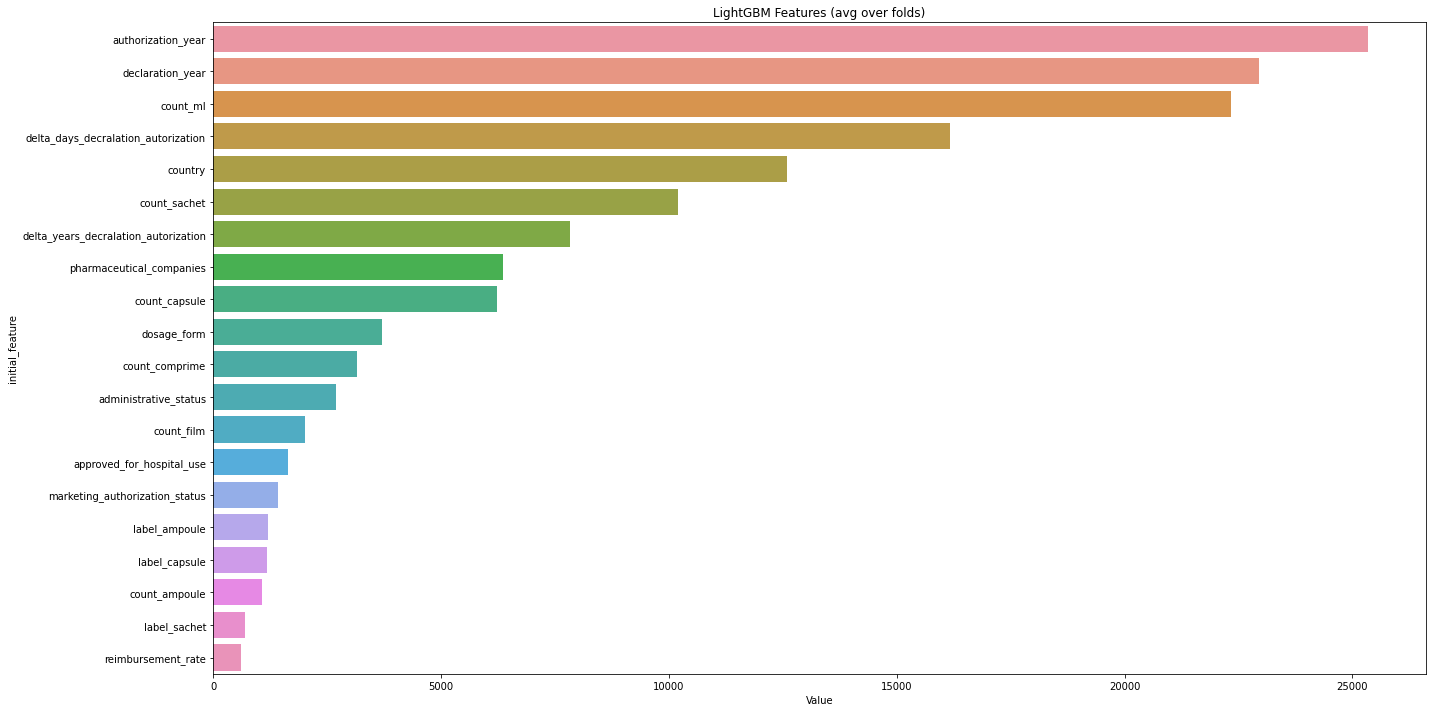

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

grouped_feature_imp[:20]
fig = plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="initial_feature", data=grouped_feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
fig.savefig('../deliveries/visualization/lgb1_importances.jpg', dpi=fig.dpi)

### SHAP

lets check local explainability

In [46]:
import shap

explainer = shap.TreeExplainer(clf)


keep_shap = [a for a in X.columns if a in clf.feature_name_]

shap_values = explainer.shap_values(X[keep_shap])

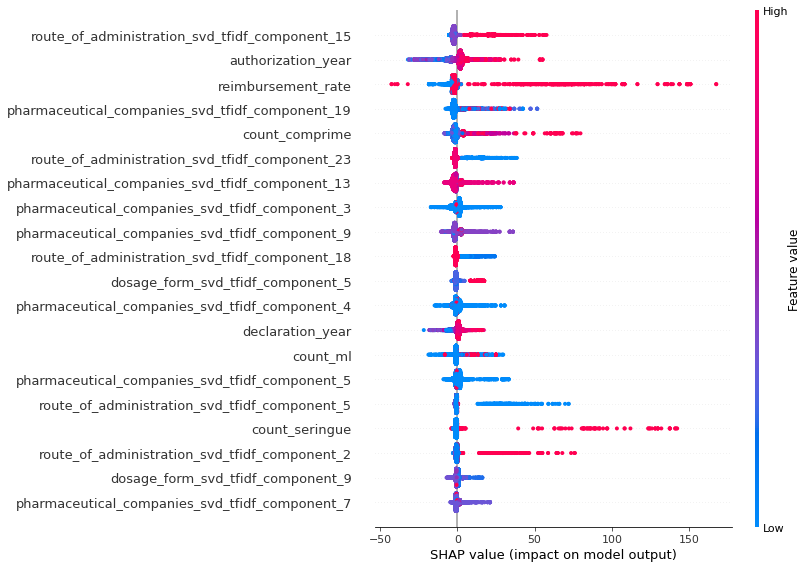

In [80]:
shap.summary_plot(shap_values, X[keep_shap])

In [48]:
import pickle
filename_expl = '../models/TreeExplainer_LGB3.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))
load_explainer = pickle.load(open(filename_expl, 'rb'))